In [6]:
pip install lime

In [7]:
pip install captum

In [8]:
from fastai.vision.all import *
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from collections import Counter
import torch
import cv2
import numpy as np
import lime
from lime import lime_image
from captum.attr import Saliency, IntegratedGradients, visualization as viz
from skimage.segmentation import mark_boundaries
import torchvision.transforms as T

In [9]:
# Paths to the dataset
train_path = Path('/content/drive/MyDrive/dataset/train')
valid_path = Path('/content/drive/MyDrive/dataset/valid')
test_path = Path('/content/drive/MyDrive/dataset/test')

# Load images
train_images = get_image_files(train_path)
valid_images = get_image_files(valid_path)
test_images = get_image_files(test_path)

print(f"No. of training images: {len(train_images)}")
print(f"No. of validation images: {len(valid_images)}")
print(f"No. of test images: {len(test_images)}")

No. of training images: 2540
No. of validation images: 100
No. of test images: 300


In [10]:
# Print image dimensions
sizes = set(Image.open(img).size for img in train_images)
print("Image Dimensions:", *sizes)

KeyboardInterrupt: 

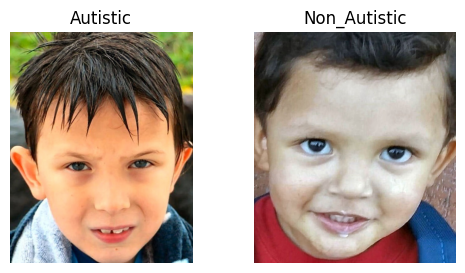

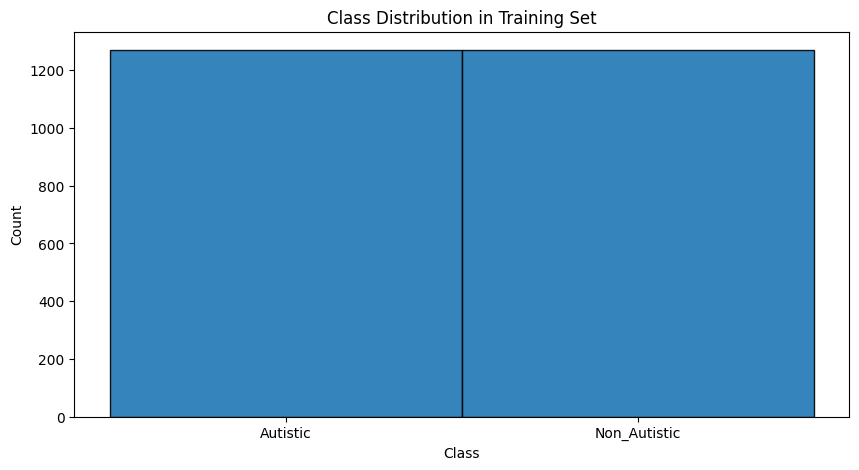

In [11]:
# Visualize some training imagesnm
images = []
target = []
counts = []
for path in train_path.ls().sorted():
    target.append(path.name)  # class name is the name of the parent folder
    class_images = get_image_files(path)
    counts.append(len(class_images))
    img = random.choice(class_images)
    images.append(Image.open(img))

show_images(images, titles=target)
print("\n\n")

# Bar chart for class distribution in training set
plt.figure(figsize=(10, 5))
plt.bar(target, counts, width=1, edgecolor='black', alpha=0.9)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Training Set')
plt.show()
print("\n\n")

In [12]:
# Data block for loading the data
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # Use RandomSplitter for validation
    get_y=parent_label,
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(size=224, p_affine=0, max_warp=0, flip_vert=True)
)

# Create DataLoaders for training and validation sets
dls = dblock.dataloaders(train_path, bs=32)

<Figure size 1000x500 with 0 Axes>

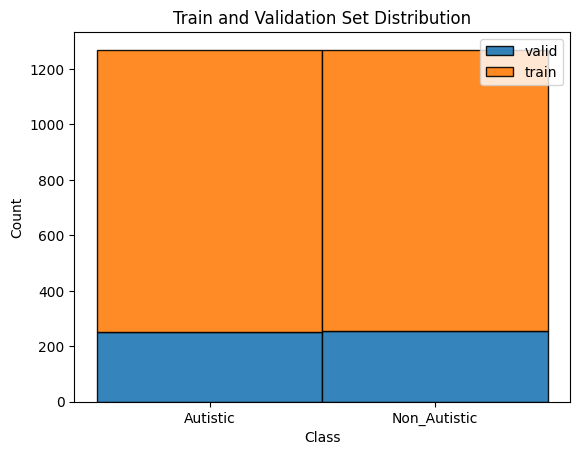

In [13]:
# Check distributions of train and validation set
train_labels = sorted(parent_label(x) for x in dls.train.items)
valid_labels = sorted(parent_label(x) for x in dls.valid.items)
ntrain = list(Counter(train_labels).values())
nvalid = list(Counter(valid_labels).values())

plt.figure(figsize=(10, 5))
ax = plt.subplots()[1]
ax.bar(target, nvalid, width=1, edgecolor='black', alpha=0.9, label='valid')
ax.bar(target, ntrain, width=1, edgecolor='black', alpha=0.9, label='train', bottom=nvalid)
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend()
plt.title('Train and Validation Set Distribution')
plt.show()
print("\n\n")

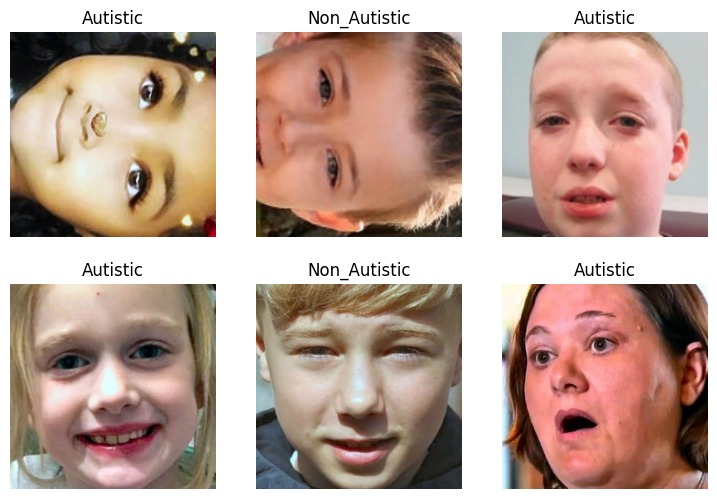

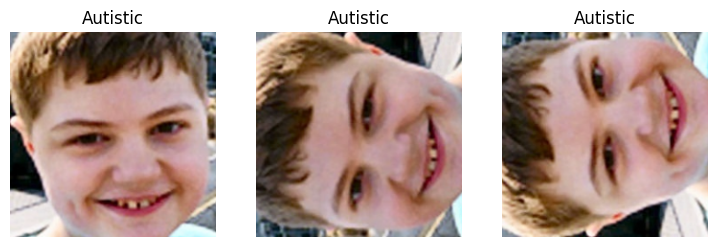

In [14]:
# Show batch of images
dls.show_batch(max_n=6, nrows=2)
dls.show_batch(max_n=3, nrows=1, unique=True)
print("\n\n")

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 191MB/s]


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.990712,0.663518,0.263780,0.736220,01:03


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.743641,0.508223,0.212598,0.787402,00:24
1,0.692793,0.491008,0.210630,0.789370,00:31
2,0.628790,0.477947,0.200787,0.799213,00:25
3,0.601837,0.465998,0.208661,0.791339,00:28
4,0.542295,0.496641,0.198819,0.801181,00:28
5,0.478927,0.489571,0.185039,0.814961,00:26
6,0.431195,0.531292,0.214567,0.785433,00:29
7,0.362889,0.518232,0.169291,0.830709,00:33
8,0.359500,0.576325,0.190945,0.809055,00:27
9,0.304362,0.460520,0.171260,0.828740,00:26


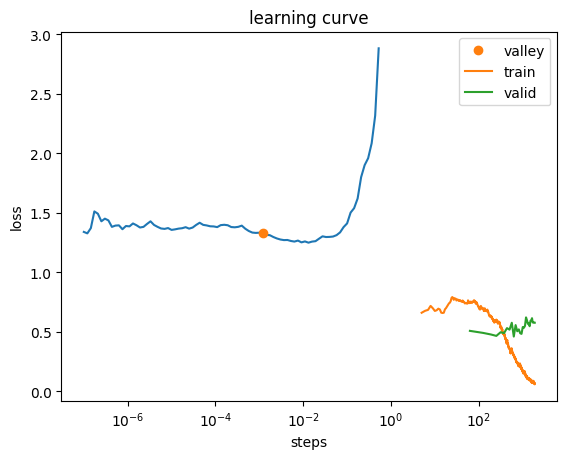

In [15]:
# Create a learner
learn = vision_learner(dls, resnet34, metrics=[error_rate, accuracy])

# Find learning rate and fine-tune the model
learn.lr_find()
print("\n\n")
learn.fine_tune(30, 0.001)

# Plot learning curve
learn.recorder.plot_loss()
print("\n\n")

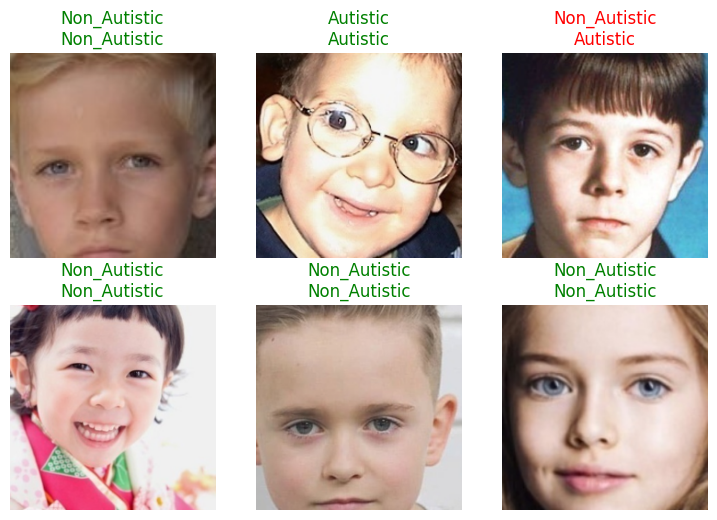

In [16]:
# Show resultssss
learn.show_results(max_n=6, nrows=2)

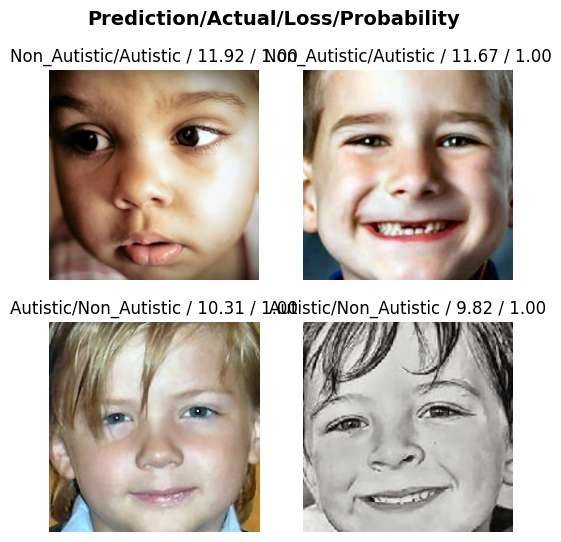

In [17]:
# Plot top losses
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(4)
print("\n\n")

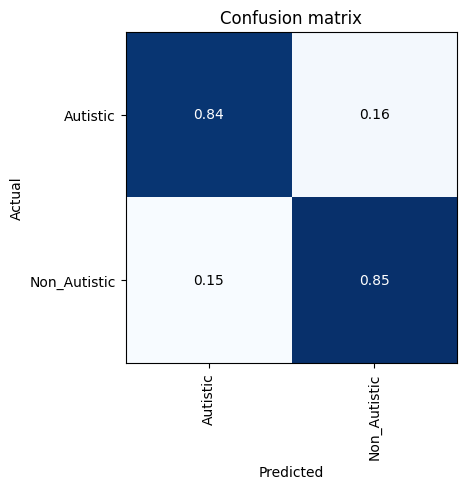

In [18]:
# Show confusion matrix of predictions on the validation set
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(normalize=True)
print("\n\n")

In [19]:
# Generate classification report
preds, y_true = learn.get_preds()
y_pred = preds.argmax(dim=1).numpy()
y_true = y_true.numpy()
y_pred_labels = [dls.vocab[idx] for idx in y_pred]
y_true_labels = [dls.vocab[idx] for idx in y_true]
report = classification_report(y_true_labels, y_pred_labels, target_names=dls.vocab)
print(report)

              precision    recall  f1-score   support

    Autistic       0.85      0.84      0.84       252
Non_Autistic       0.84      0.85      0.85       256

    accuracy                           0.84       508
   macro avg       0.84      0.84      0.84       508
weighted avg       0.84      0.84      0.84       508



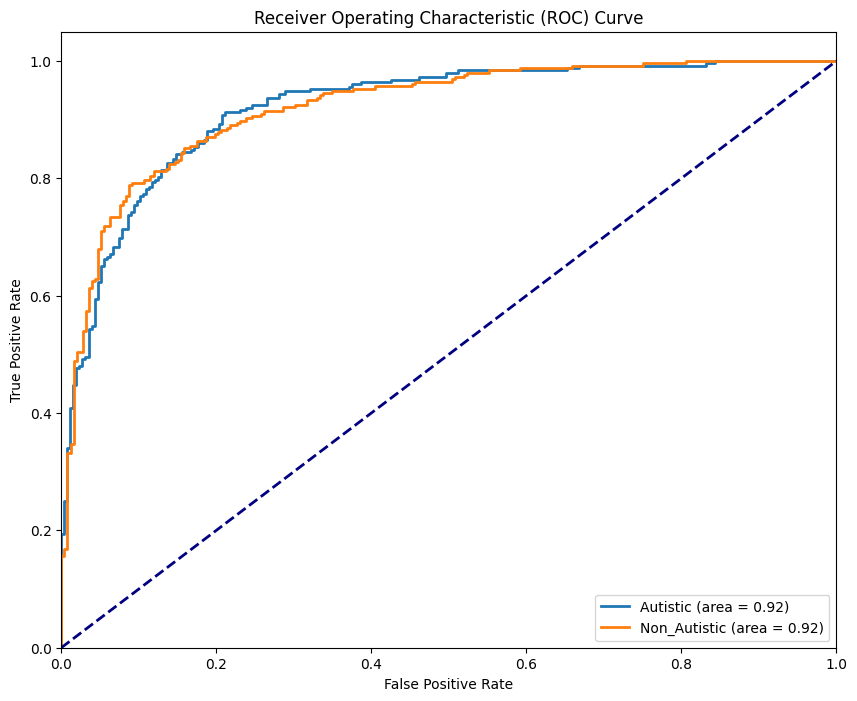

In [20]:
# ROC Curve python
fpr = {}
tpr = {}
roc_auc = {}

for i, label in enumerate(dls.vocab):
    fpr[label], tpr[label], _ = roc_curve(y_true == i, preds[:, i])
    roc_auc[label] = auc(fpr[label], tpr[label])

plt.figure(figsize=(10, 8))
for label in dls.vocab:
    plt.plot(fpr[label], tpr[label], lw=2, label=f'{label} (area = {roc_auc[label]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [21]:
def generate_gradcam(learn, img, cls_idx):
    learn.model.eval()
    img = img.unsqueeze(0).to(next(learn.model.parameters()).device)  # Ensure image tensor is on the same device as model

    def hooked_backward(mod, grad_in, grad_out):
        global activations
        activations = grad_out[0]

    def hooked_forward(mod, input, output):
        global hook_a
        hook_a = output

    for module in learn.model[0]:
        if isinstance(module, torch.nn.modules.conv.Conv2d):
            hook = module.register_forward_hook(hooked_forward)
            grad = module.register_full_backward_hook(hooked_backward)

    learn.model.zero_grad()
    out = learn.model(img)
    out[0, cls_idx].backward()

    weights = activations.mean(dim=[1, 2], keepdim=True)
    gradcam = (hook_a * weights).sum(0)
    gradcam = torch.clamp(gradcam, min=0)
    gradcam /= gradcam.max()
    gradcam = gradcam.detach().cpu().numpy()

    grad.remove()
    hook.remove()

    return gradcam

In [22]:
# Test Grad-CAM on validation set images
img, label = dls.valid_ds[0]
img_tensor = tensor(img).float()
img_tensor = img_tensor.permute(2, 0, 1)
cls_idx = int(label)
gradcam = generate_gradcam(learn, img_tensor.cuda(), cls_idx)

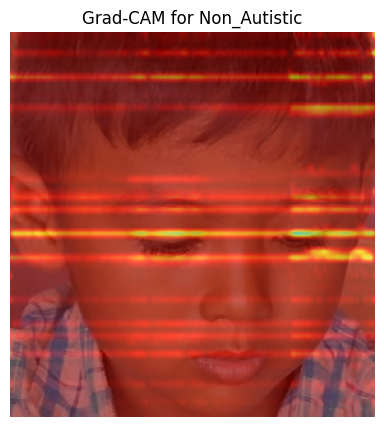

In [23]:
# Resize Grad-CAM heatmap to match image dimensions
heatmap_resized = cv2.resize(gradcam, (img_tensor.shape[1], img_tensor.shape[2]))

# Normalize the heatmap
heatmap_resized = np.uint8(255 * heatmap_resized)

# Ensure heatmap is 2D
if len(heatmap_resized.shape) == 3:
    heatmap_resized = heatmap_resized[:,:,0]

# Apply the color map
heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

# Convert PIL image to numpy array
img = np.array(img)

# Ensure the heatmap and the image have the same number of channels
if img.shape[2] == 4:  # If image is RGBA
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

# Ensure the image and the heatmap have the same dimensions
heatmap_resized = cv2.resize(heatmap_resized, (img.shape[1], img.shape[0]))

# Deeply highlight the gradient region
overlay = cv2.addWeighted(img, 0.4, heatmap_resized, 0.6, 0)

# Display Grad-CAM
plt.figure(figsize=(10, 5))
plt.imshow(overlay)
plt.title(f'Grad-CAM for {dls.vocab[cls_idx]}')
plt.axis('off')
plt.show()


In [24]:
# Grad-CAM++
def generate_gradcam_pp(learn, img, cls_idx):
    learn.model.eval()
    device = next(learn.model.parameters()).device  # Get the device of the model

    # Ensure image tensor is on the same device as model
    img = img.unsqueeze(0).to(device)

    activations = None
    gradients = None

    def hooked_backward(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_in[0]

    def hooked_forward(module, input, output):
        nonlocal activations
        activations = output

    # Find the last convolutional layer and register hooks
    for module in reversed(list(learn.model.modules())):
        if isinstance(module, torch.nn.Conv2d):
            hook_a = module.register_forward_hook(hooked_forward)
            hook_g = module.register_full_backward_hook(hooked_backward)
            break

    # Perform forward and backward pass
    output = learn.model(img)
    learn.model.zero_grad()
    score = output[0, cls_idx]
    score.backward(retain_graph=True)

    # Compute Grad-CAM++
    weights = gradients.pow(2)
    alpha = weights / (weights.sum(dim=(2, 3), keepdim=True) + 1e-7)
    gradcam_pp = (alpha * activations).sum(dim=1, keepdim=True).relu().squeeze().detach().cpu().numpy()
    gradcam_pp = gradcam_pp / gradcam_pp.max()

    # Remove hooks
    hook_a.remove()
    hook_g.remove()

    return gradcam_pp

<ipython-input-24-f746b765625b>:37: RuntimeWarning: invalid value encountered in divide
  gradcam_pp = gradcam_pp / gradcam_pp.max()
<ipython-input-25-12c529b03874>:8: RuntimeWarning: invalid value encountered in cast
  heatmap_pp_resized = np.uint8(255 * heatmap_pp_resized)


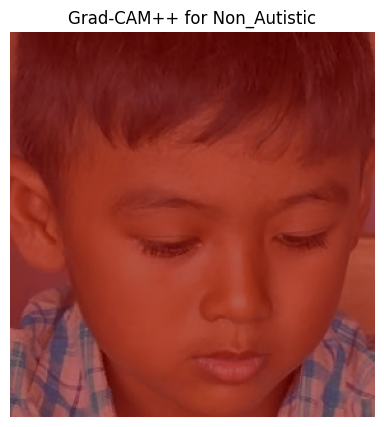

In [25]:
# Test Grad-CAM++ on validation set images
gradcam_pp = generate_gradcam_pp(learn, img_tensor.cuda(), cls_idx)

# Resize Grad-CAM++ heatmap to match image dimensions
heatmap_pp_resized = cv2.resize(gradcam_pp, (img_tensor.shape[1], img_tensor.shape[2]))

# Normalize the heatmap
heatmap_pp_resized = np.uint8(255 * heatmap_pp_resized)

# Ensure heatmap is 2D
if len(heatmap_pp_resized.shape) == 3:
    heatmap_pp_resized = heatmap_pp_resized[:,:,0]

# Apply the color map
heatmap_pp_resized = cv2.applyColorMap(heatmap_pp_resized, cv2.COLORMAP_JET)

# Ensure the image and the heatmap have the same dimensions
heatmap_pp_resized = cv2.resize(heatmap_pp_resized, (img.shape[1], img.shape[0]))

# Deeply highlight the gradient region
overlay_pp = cv2.addWeighted(img, 0.4, heatmap_pp_resized, 0.6, 0)

# Display Grad-CAM++
plt.figure(figsize=(10, 5))
plt.imshow(overlay_pp)
plt.title(f'Grad-CAM++ for {dls.vocab[cls_idx]}')
plt.axis('off')
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

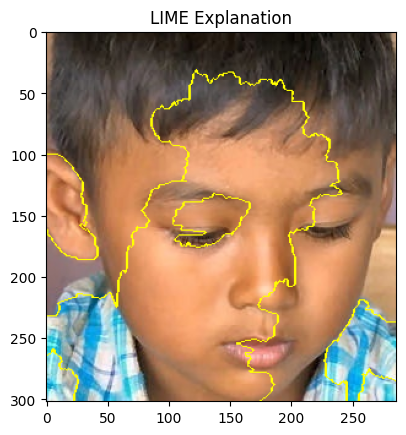

In [32]:
def lime_explanation(img):
    def predict(images):
        images = torch.stack([vision_transform(im) for im in images])
        preds = learn.model(images.cuda())
        return preds.softmax(dim=1).cpu().detach().numpy()

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(np.array(img), predict, top_labels=1, hide_color=0, num_samples=1000)

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=30, hide_rest=False)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title('LIME Explanation')
    plt.show()

# Vision transform to convert PIL image to tensor
def vision_transform(img):
    transform = T.ToTensor()
    return transform(img)

# Test LIME explanation
lime_explanation(img)

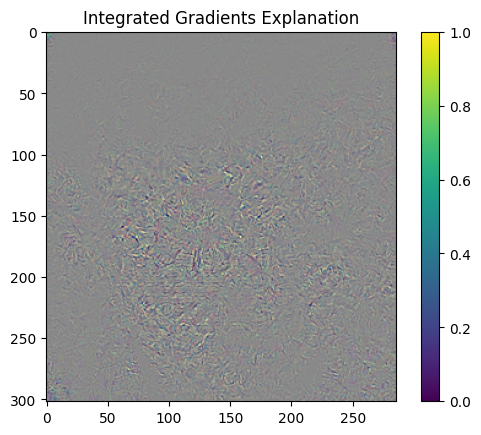

In [33]:
def integrated_gradients_explanation(learn, img_tensor):
    img_tensor = img_tensor.unsqueeze(0).cuda()  # Ensure tensor is on GPU
    ig = IntegratedGradients(learn.model)

    # Baseline is a black image (all zeros)
    baselines = img_tensor * 0

    # Compute attributions
    attributions = ig.attribute(img_tensor, target=cls_idx, baselines=baselines)

    # Convert attributions to numpy array
    attr_np = attributions.squeeze().detach().cpu().numpy().transpose(1, 2, 0)

    # Normalize attributions for visualization
    attr_np = (attr_np - attr_np.min()) / (attr_np.max() - attr_np.min())

    # Display attributions
    plt.imshow(attr_np, cmap='viridis')
    plt.title('Integrated Gradients Explanation')
    plt.colorbar()
    plt.show()

# Example call to the function with 'learn' as the model and 'img_tensor' as the input image tensor
img, label = dls.valid_ds[0]
img_tensor = tensor(img).float()  # Convert PIL image to PyTorch tensor
img_tensor = img_tensor.permute(2, 0, 1)  # Permute dimensions to match expected input shape
integrated_gradients_explanation(learn, img_tensor)

/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


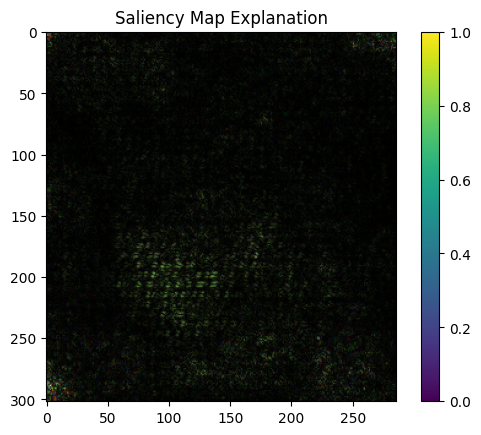

In [34]:
def saliency_map_explanation(learn, img_tensor):
    img_tensor = img_tensor.unsqueeze(0).cuda()  # Ensure tensor is on GPU
    saliency = Saliency(learn.model)

    # Compute attributions
    attributions = saliency.attribute(img_tensor, target=cls_idx)

    # Convert attributions to numpy array
    attr_np = attributions.squeeze().detach().cpu().numpy().transpose(1, 2 , 0)

    # Normalize attributions for visualization
    attr_np = (attr_np - attr_np.min()) / (attr_np.max() - attr_np.min())

    # Display attributions
    plt.imshow(attr_np, cmap='viridis')
    plt.title('Saliency Map Explanation')
    plt.colorbar()
    plt.show()

# Example call to the function with 'learn' as the model and 'img_tensor' as the input image tensor
img, label = dls.valid_ds[0]
img_tensor = tensor(img).float()  # Convert PIL image to PyTorch tensor
img_tensor = img_tensor.permute(2, 0, 1)  # Permute dimensions to match expected input shape
saliency_map_explanation(learn, img_tensor)

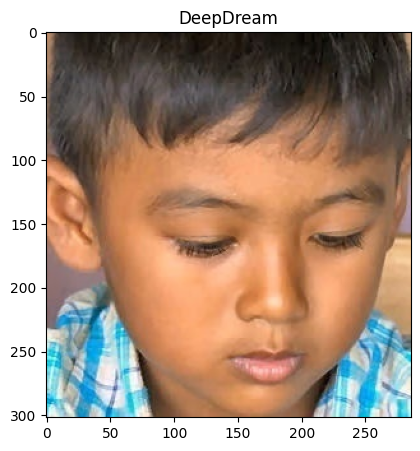

In [35]:
# DeepDream implementation
def deepdream(img_tensor, model, iterations, lr):
    model.eval()
    img_tensor = img_tensor.unsqueeze(0).to(next(model.parameters()).device)  # Ensure tensor is on the same device as model
    img_tensor.requires_grad = True

    for i in range(iterations):
        model.zero_grad()
        out = model(img_tensor)
        loss = out.norm()
        loss.backward()
        img_tensor.data += lr * img_tensor.grad.data
        img_tensor.grad.data.zero_()

    # Deeply highlight the regions
    deepdream_img = img_tensor.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
    deepdream_img = (deepdream_img - deepdream_img.min()) / (deepdream_img.max() - deepdream_img.min())

    return deepdream_img

# Test DeepDream on validation set image
deepdream_img = deepdream(img_tensor, learn.model, iterations=10, lr=0.01)

# Display DeepDream result
plt.figure(figsize=(10, 5))
plt.imshow(deepdream_img)
plt.title('DeepDream')
plt.show()

In [36]:
# Apply interpretability techniques on an image from each category
for category in target:
    print(f"Category: {category}")
    class_images = get_image_files(train_path/category)
    img_path = random.choice(class_images)
    img = Image.open(img_path)
    img_tensor = tensor(img).float()  # Convert PIL image to PyTorch tensor
    img_tensor = img_tensor.permute(2, 0, 1)  # Permute dimensions to match expected input shape

    # Grad-CAM
    cls_idx = dls.vocab.o2i[category]  # Correct way to get the index of the category
    gradcam = generate_gradcam(learn, img_tensor.cuda(), cls_idx)

    # Resize Grad-CAM heatmap to match image dimensions
    heatmap_resized = cv2.resize(gradcam, (img_tensor.shape[1], img_tensor.shape[2]))

    # Normalize the heatmap
    heatmap_resized = np.uint8(255 * heatmap_resized)

    # Ensure heatmap is 2D
    if len(heatmap_resized.shape) == 3:
        heatmap_resized = heatmap_resized[:,:,0]

    # Apply the color map
    heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Convert PIL image to numpy array
    img = np.array(img)

    # Ensure the heatmap and the image have the same number of channels
    if img.shape[2] == 4:  # If image is RGBA
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

    # Ensure the image and the heatmap have the same dimensions
    heatmap_resized = cv2.resize(heatmap_resized, (img.shape[1], img.shape[0]))

    # Deeply highlight the gradient region
    overlay = cv2.addWeighted(img, 0.4, heatmap_resized, 0.6, 0)

    # Display Grad-CAM
    plt.figure(figsize=(10, 5))
    plt.imshow(overlay)
    plt.title(f'Grad-CAM for {dls.vocab[cls_idx]}')
    plt.axis('off')
    plt.show()

    # Grad-CAM++
    # Test Grad-CAM++ on validation set images
    gradcam_pp = generate_gradcam_pp(learn, img_tensor.cuda(), cls_idx)

    # Resize Grad-CAM++ heatmap to match image dimensions
    heatmap_pp_resized = cv2.resize(gradcam_pp, (img_tensor.shape[1], img_tensor.shape[2]))

    # Normalize the heatmap
    heatmap_pp_resized = np.uint8(255 * heatmap_pp_resized)

    # Ensure heatmap is 2D
    if len(heatmap_pp_resized .shape) == 3:
        heatmap_pp_resized = heatmap_pp_resized[:,:,0]

    # Apply the color map
    heatmap_pp_resized = cv2.applyColorMap(heatmap_pp_resized, cv2.COLORMAP_JET)

    # Ensure the image and the heatmap have the same dimensions
    heatmap_pp_resized = cv2.resize(heatmap_pp_resized, (img.shape[1], img.shape[0]))

    # Deeply highlight the gradient region
    overlay_pp = cv2.addWeighted(img, 0.4, heatmap_pp_resized, 0.6, 0)

    # Display Grad-CAM++
    plt.figure(figsize=(10, 5))
    plt.imshow(overlay_pp)
    plt.title(f'Grad-CAM++ for {dls.vocab[cls_idx]}')
    plt.axis('off')
    plt.show()

    # LIME
    lime_explanation(img)

    # Integrated Gradients
    integrated_gradients_explanation(learn, img_tensor)

    # Saliency Map
    saliency_map_explanation(learn, img_tensor)

    # DeepDream
    deepdream_img = deepdream(img_tensor, learn.model, iterations=10, lr=0.01)
    plt.figure(figsize=(10, 5))
    plt.imshow(deepdream_img)
    plt.title(f'DeepDream for {category}')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [38]:
# Save the model to Google Drive
model_path_drive = '/content/drive/MyDrive/my_model.pth'
torch.save(learn.model.state_dict(), model_path_drive)

In [39]:
# Save the learner to Google Drive
learner_path_drive = '/content/drive/MyDrive/my_learner.pkl'
learn.export(learner_path_drive)